In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
%autoreload

cohort = mre_pinn.data.PatientCohort(xarray_dir='../data/NAFLD', patient_ids='0006')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/mask.nc
100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


In [4]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [12]:
%autoreload

pino = mre_pinn.model.pino.PINO(
    n_spatial_dims=3,
    n_channels_in=4,
    n_channels_out=1,
    n_blocks=0,
    n_modes=128,
    activ_fn='g'
)
pino

PINO(
  (spectral): SpectralTransform(n_spatial_dims=3, n_channels_in=4, n_channels_out=1, n_modes=128)
)

In [13]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-8, 1e0],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000208 s



Training model...

Step      Train loss              Test loss               Test metric
0         [3.34e-06, 3.34e+02]    [3.34e-06, 3.34e+02]    []  


<IPython.core.display.Javascript object>


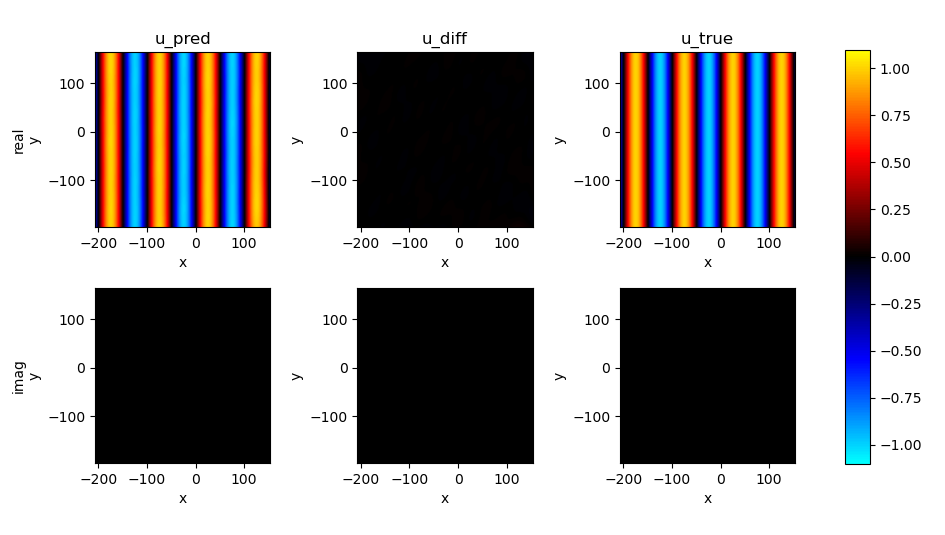

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

Time spent testing: 15.58%
10        [7.70e-08, 7.70e+00]    [7.70e-08, 7.70e+00]    []  
Time spent testing: 14.17%
20        [2.18e-08, 2.18e+00]    [2.18e-08, 2.18e+00]    []  
Time spent testing: 13.72%
30        [1.11e-08, 1.11e+00]    [1.11e-08, 1.11e+00]    []  
Time spent testing: 13.52%
40        [5.19e-09, 5.19e-01]    [5.19e-09, 5.19e-01]    []  
Time spent testing: 13.42%
50        [2.37e-09, 2.37e-01]    [2.37e-09, 2.37e-01]    []  
Time spent testing: 13.35%
60        [1.21e-09, 1.21e-01]    [1.21e-09, 1.21e-01]    []  
Time spent testing: 13.30%
70        [6.56e-10, 6.56e-02]    [6.56e-10, 6.56e-02]    []  
Time spent testing: 13.24%
80        [3.57e-10, 3.57e-02]    [3.57e-10, 3.57e-02]    []  
Time spent testing: 13.18%
90        [2.13e-10, 2.13e-02]    [2.13e-10, 2.13e-02]    []  
Time spent testing: 13.12%
100       [1.31e-10, 1.31e-02]    [1.31e-10, 1.31e-02]    []  
Time spent testing: 13.07%
110       [8.69e-11, 8.69e-03]    [8.69e-11, 8.69e-03]    []  
Time spent

920       [2.58e-13, 2.58e-05]    [2.58e-13, 2.58e-05]    []  
Time spent testing: 12.13%
930       [2.52e-13, 2.52e-05]    [2.52e-13, 2.52e-05]    []  
Time spent testing: 12.13%
940       [2.46e-13, 2.46e-05]    [2.46e-13, 2.46e-05]    []  


In [ ]:
model.train(1000, display_every=10, callbacks=[test_eval])